# Fine-Tuned ResNet-18 for clothes classification 

For architecture I chose pretrained on ImageNet 18-layer Residual Neural Network
![Architecture]()
## Dataset
I found kaggle competition ['iMaterialist Challenge'](https://www.kaggle.com/c/imaterialist-challenge-fashion-2018) with 1 milion images and their annotations.

# Import

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
# define device for training   
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

CUDA is available!  Training on GPU ...


In [2]:
import numpy as np
import pandas as pd
import os, time, re, io
import json


from tqdm import tqdm_notebook
from PIL import Image
from pathlib import Path
import urllib

import torchvision
from torchvision import transforms
from sklearn.metrics import f1_score

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# ignore matplotlib unuseful warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [37]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# [iMaterialist Dataset](https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/data)

Sizes of train and test dataset.

In [3]:
TRAIN_SIZE = 15000

# constant input size for pretrained ResNet-18 on ImageNet
RESCALE_SIZE = 224

Features csv table with pairs id - annotations

In [4]:
feature_map = pd.read_csv('files/iMat_fashion_2018_label_map_228.csv')

In [5]:
with open("files/train.json", "r") as train_json:
    train_dict = json.load(train_json)

## Download images
train.json contains urls with ids 

In [6]:
def get_dataset(train_dict):
    if not os.path.exists('files/train'):
        os.makedirs('files/train')
        print('download train dataset...')            
        for image in tqdm_notebook(train_dict['images'][:TRAIN_SIZE]):
            try:
                urllib.request.urlretrieve(image['url'], 'files/train/{}.jpg'.format(image['imageId']))
            except:
                pass
        print('done')
    else:
        print('train folder already exists')

In [7]:
get_dataset(train_dict)

train folder already exists


In [8]:
TRAIN_DIR = Path('files/train/')

Little part of urls not found and we have not 15000 images.

In [9]:
REAL_TRAIN_SIZE = 12000
REAL_VAL_SIZE = len(list(TRAIN_DIR.rglob('*.jpg'))) - REAL_TRAIN_SIZE # ~2500 images

In [10]:
train_files = list(TRAIN_DIR.rglob('*.jpg'))[:REAL_TRAIN_SIZE]
# sort by number in title
train_files.sort(key=lambda f: int(re.sub('\D', '', f.name)))

val_files = list(TRAIN_DIR.rglob('*.jpg'))[REAL_TRAIN_SIZE:]
val_files.sort(key=lambda f: int(re.sub('\D', '', f.name)))

Feature map contains not only category of clothes.

In [11]:
categorical_feature_map = feature_map[feature_map['taskName'] == 'category']

Enumerating classes.

In [12]:
categorical_feature_map['numerical'] = np.array(range(len(categorical_feature_map)))

/home/philipp/anaconda3/envs/clothes-classification/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
categorical_feature_map

,labelId,taskId,labelName,taskName,numerical
2,3,1,Athletic Pants,category,0
3,4,1,Athletic Sets,category,1
4,5,1,Athletic Shirts,category,2
5,6,1,Athletic Shorts,category,3
7,8,1,Baggy Jeans,category,4
...,...,...,...,...,...
216,217,1,Vests,category,100
219,220,1,Wedding Dresses,category,101
220,221,1,Wedges & Platforms,category,102
222,223,1,Winter Boots,category,103


In [14]:
num_classes = len(categorical_feature_map)

## Dataset class

In [60]:
class FashionDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, dictionary, categorical_feature_map=categorical_feature_map):
        super().__init__()
        
        self.files = files
        self.dictionary = dictionary
        self.categorical_feature_map = categorical_feature_map
        self.mode = mode
        
        # get id from filename
        self.ids = np.array(sorted([int(path.name[:-4]) for path in self.files]))
        
        self.labels = []
        ids_for_remove = []
        for id_ in self.ids:
            label_ = list(map(int, self.dictionary['annotations'][id_ - 1]['labelId']))
            label = 0
            for l in label_:
                if l in self.categorical_feature_map['labelId'].values:
                    label = self.categorical_feature_map[self.categorical_feature_map['labelId'] == l]['numerical'].values[0]
                    break
            if not label:
                ids_for_remove.append(id_)
            else:
                self.labels.append(label)
        self.labels = np.array(self.labels)
        
        # drop images withot 'category' class
        self.ids = np.setdiff1d(self.ids, ids_for_remove)
        
        self.len_ = len(self.ids)
        
        # get text labels of classes from map
        self.text_labels = []
        for label in self.labels:
            text_label = self.categorical_feature_map[self.categorical_feature_map['numerical'] == label]['labelName'].values[0] 
            self.text_labels.append(text_label)
        self.text_labels = np.array(self.text_labels)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __getitem__(self, index):
        # convert to tensor and normalize
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        # augmentations for the increase of train dataset
        augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(224, scale=(0.8, 1), ratio=(0.75, 1.3333333333333333), interpolation=2),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.9, interpolation=3),
            transforms.RandomAffine(degrees=20, shear=20, resample=False),
            transforms.Resize((224, 224))
        ])
        
#         x = self.load_sample(self.files[index])
        id_ = self.ids[index]
        x = self.load_sample(Path(self.files[0].parent.as_posix() + '/{}.jpg'.format(id_)))
        if self.mode == 'train':
            x = augmentation(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        
        text_label = self.text_labels[index]
        y = self.labels[index]
        return x, y, text_label
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [61]:
train_dataset = FashionDataset(train_files, 'train', train_dict, categorical_feature_map)
val_dataset = FashionDataset(val_files, 'val', train_dict, categorical_feature_map)

In [62]:
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4, shuffle=True)

In [63]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure()
    plt_ax.imshow(inp)
    if title is not None:
        fig.suptitle(title)
    plt_ax.grid(False)

Example of train image in with random augmentations

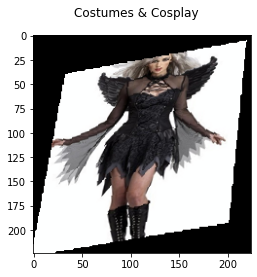

In [64]:
imshow(train_dataset[26][0], train_dataset[26][2])

Val image:

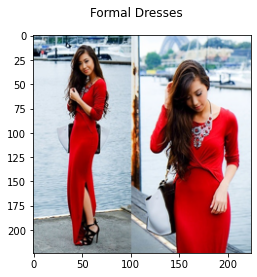

In [65]:
imshow(val_dataset[2][0], val_dataset[2][2])

# Train

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels, text_labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

Описание эпохи валидации.

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    val_preds = []
    val_labels = []
    
    for inputs, labels, text_labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            
        val_preds += preds.tolist()
        val_labels += labels.tolist()      
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    return val_loss, val_acc, val_f1

In [40]:
def train(train_dataloader, val_dataloader, model, epochs, opt, criterion, scheduler):

    start_time = time.time()
    history = []
    history_f1 = []
    log_template = "\nEpoch {:03d} train_loss: {:0.4f} \
    val_loss {:0.4f} train_acc {:0.4f} val_acc {:0.4f} val_f1 {:0.4f}"
    
    
    for epoch in tqdm_notebook(range(epochs)):
        train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, opt)
        val_loss, val_acc, val_f1 = eval_epoch(model, val_dataloader, criterion)
        print(log_template.format(epoch, train_loss, val_loss, train_acc, val_acc, val_f1))
        
        history.append((train_loss, train_acc, val_loss, val_acc))
        history_f1.append(val_f1)
        scheduler.step(val_acc)
    
    end_time = time.time()
    
    print('total time:',end_time-start_time)
    print('average time per epoch:',(end_time-start_time)/epochs)
    return history, history_f1, best_f1

In [24]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

I chose pretrained ResNet on ImageNet, because size of train set is little.
With help feature extractor i cant give high result. I will unfreeze 2 last blocks of resnet.

In [25]:
from torchvision import models

For faster training.

In [26]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =  True 
torch.backends.cudnn.deterministic = False

In [27]:
model_resnet = models.resnet18(pretrained=True).to(DEVICE)

Look at the architecture.

In [28]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# freeze all layers
for param in model_resnet.parameters():
    param.requires_grad = False

In [30]:
model_resnet.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True).to(DEVICE)

In [31]:
# unfrezee 2 layers
for param in model_resnet.layer4.parameters():
    param.requires_grad = True
for param in model_resnet.fc.parameters():
    param.requires_grad = True

Обьявим необходимые параметры для обучения. Обращу внимание на шедулер, который уменьшает скорость обучение, когда выбранная метрика перестает улучшаться, поэтому в sheduler.step передается параметр metrics, в данном случае accuracy на валидации. 

In [71]:
opt = torch.optim.Adam(model_resnet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.1, patience=3, verbose=False)
criterion = nn.CrossEntropyLoss()

Почистим мусор в памяти, в том числе и в GPU.

In [33]:
import gc
gc.collect()

5430

Обучим на 30 эпохах:

In [66]:
im, l, t = iter(train_dataloader).next()

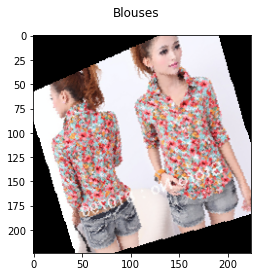

In [68]:
imshow(im[0], t[0])

In [ ]:
history, history_f1, best_f1 = train(train_dataloader, val_dataloader, model=model_resnet, epochs=20, 
                                     opt=opt, criterion=criterion, scheduler=scheduler)


Epoch 000 train_loss: 2.3062     val_loss 2.5853 train_acc 0.3614 val_acc 0.3365 val_f1 0.1353

Epoch 001 train_loss: 2.2166     val_loss 2.6917 train_acc 0.3761 val_acc 0.3476 val_f1 0.1471

Epoch 002 train_loss: 2.1476     val_loss 2.5562 train_acc 0.3836 val_acc 0.3419 val_f1 0.1373

Epoch 003 train_loss: 2.0886     val_loss 2.5428 train_acc 0.4017 val_acc 0.3485 val_f1 0.1402


Сохраним веса, чтобы не потерять полученный результат.

In [ ]:
torch.save(model_resnet_ft.state_dict(), "resnet__weights.pth") 

Изобразим результат.

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()